In [1]:
import numpy as np, matplotlib.pyplot as plt
ref = dict(np.load("refprops.npz", allow_pickle=True))
cea = dict(np.load("CEAprops.npz", allow_pickle=True))

In [2]:
print(ref.keys())
print(cea.keys())

dict_keys(['D', 'V', 'E', 'H', 'S', 'CP', 'CP/CV', 'W', 'M', 'VIS', 'TCX', 'PRANDTL', 'G'])
dict_keys(['RHO', 'H', 'U', 'G', 'S', 'M', 'GAMMAs', 'SON_VEL', 'VISC', 'Cp', 'CONDUCTIVITY', 'PRANDTL_NUMBER', 'VOLUME'])


In [3]:
ref2 = dict(); cea2 = dict()
map = {'D':'RHO', 'V':'VOLUME', 'E': 'U', 'H':'H', 'S':'S', 'CP':'Cp', 'CP/CV':'GAMMAs', 'W':'SON_VEL', 
       'M':'M', 'VIS':'VISC', 'TCX':'CONDUCTIVITY', 'PRANDTL':'PRANDTL_NUMBER', 'G':'G'}

for refkey, ceakey in map.items():
    ref2[ceakey] = ref[refkey]
    cea2[ceakey] = cea[ceakey]
print(ref2.keys())
print(cea2.keys())

dict_keys(['RHO', 'VOLUME', 'U', 'H', 'S', 'Cp', 'GAMMAs', 'SON_VEL', 'M', 'VISC', 'CONDUCTIVITY', 'PRANDTL_NUMBER', 'G'])
dict_keys(['RHO', 'VOLUME', 'U', 'H', 'S', 'Cp', 'GAMMAs', 'SON_VEL', 'M', 'VISC', 'CONDUCTIVITY', 'PRANDTL_NUMBER', 'G'])


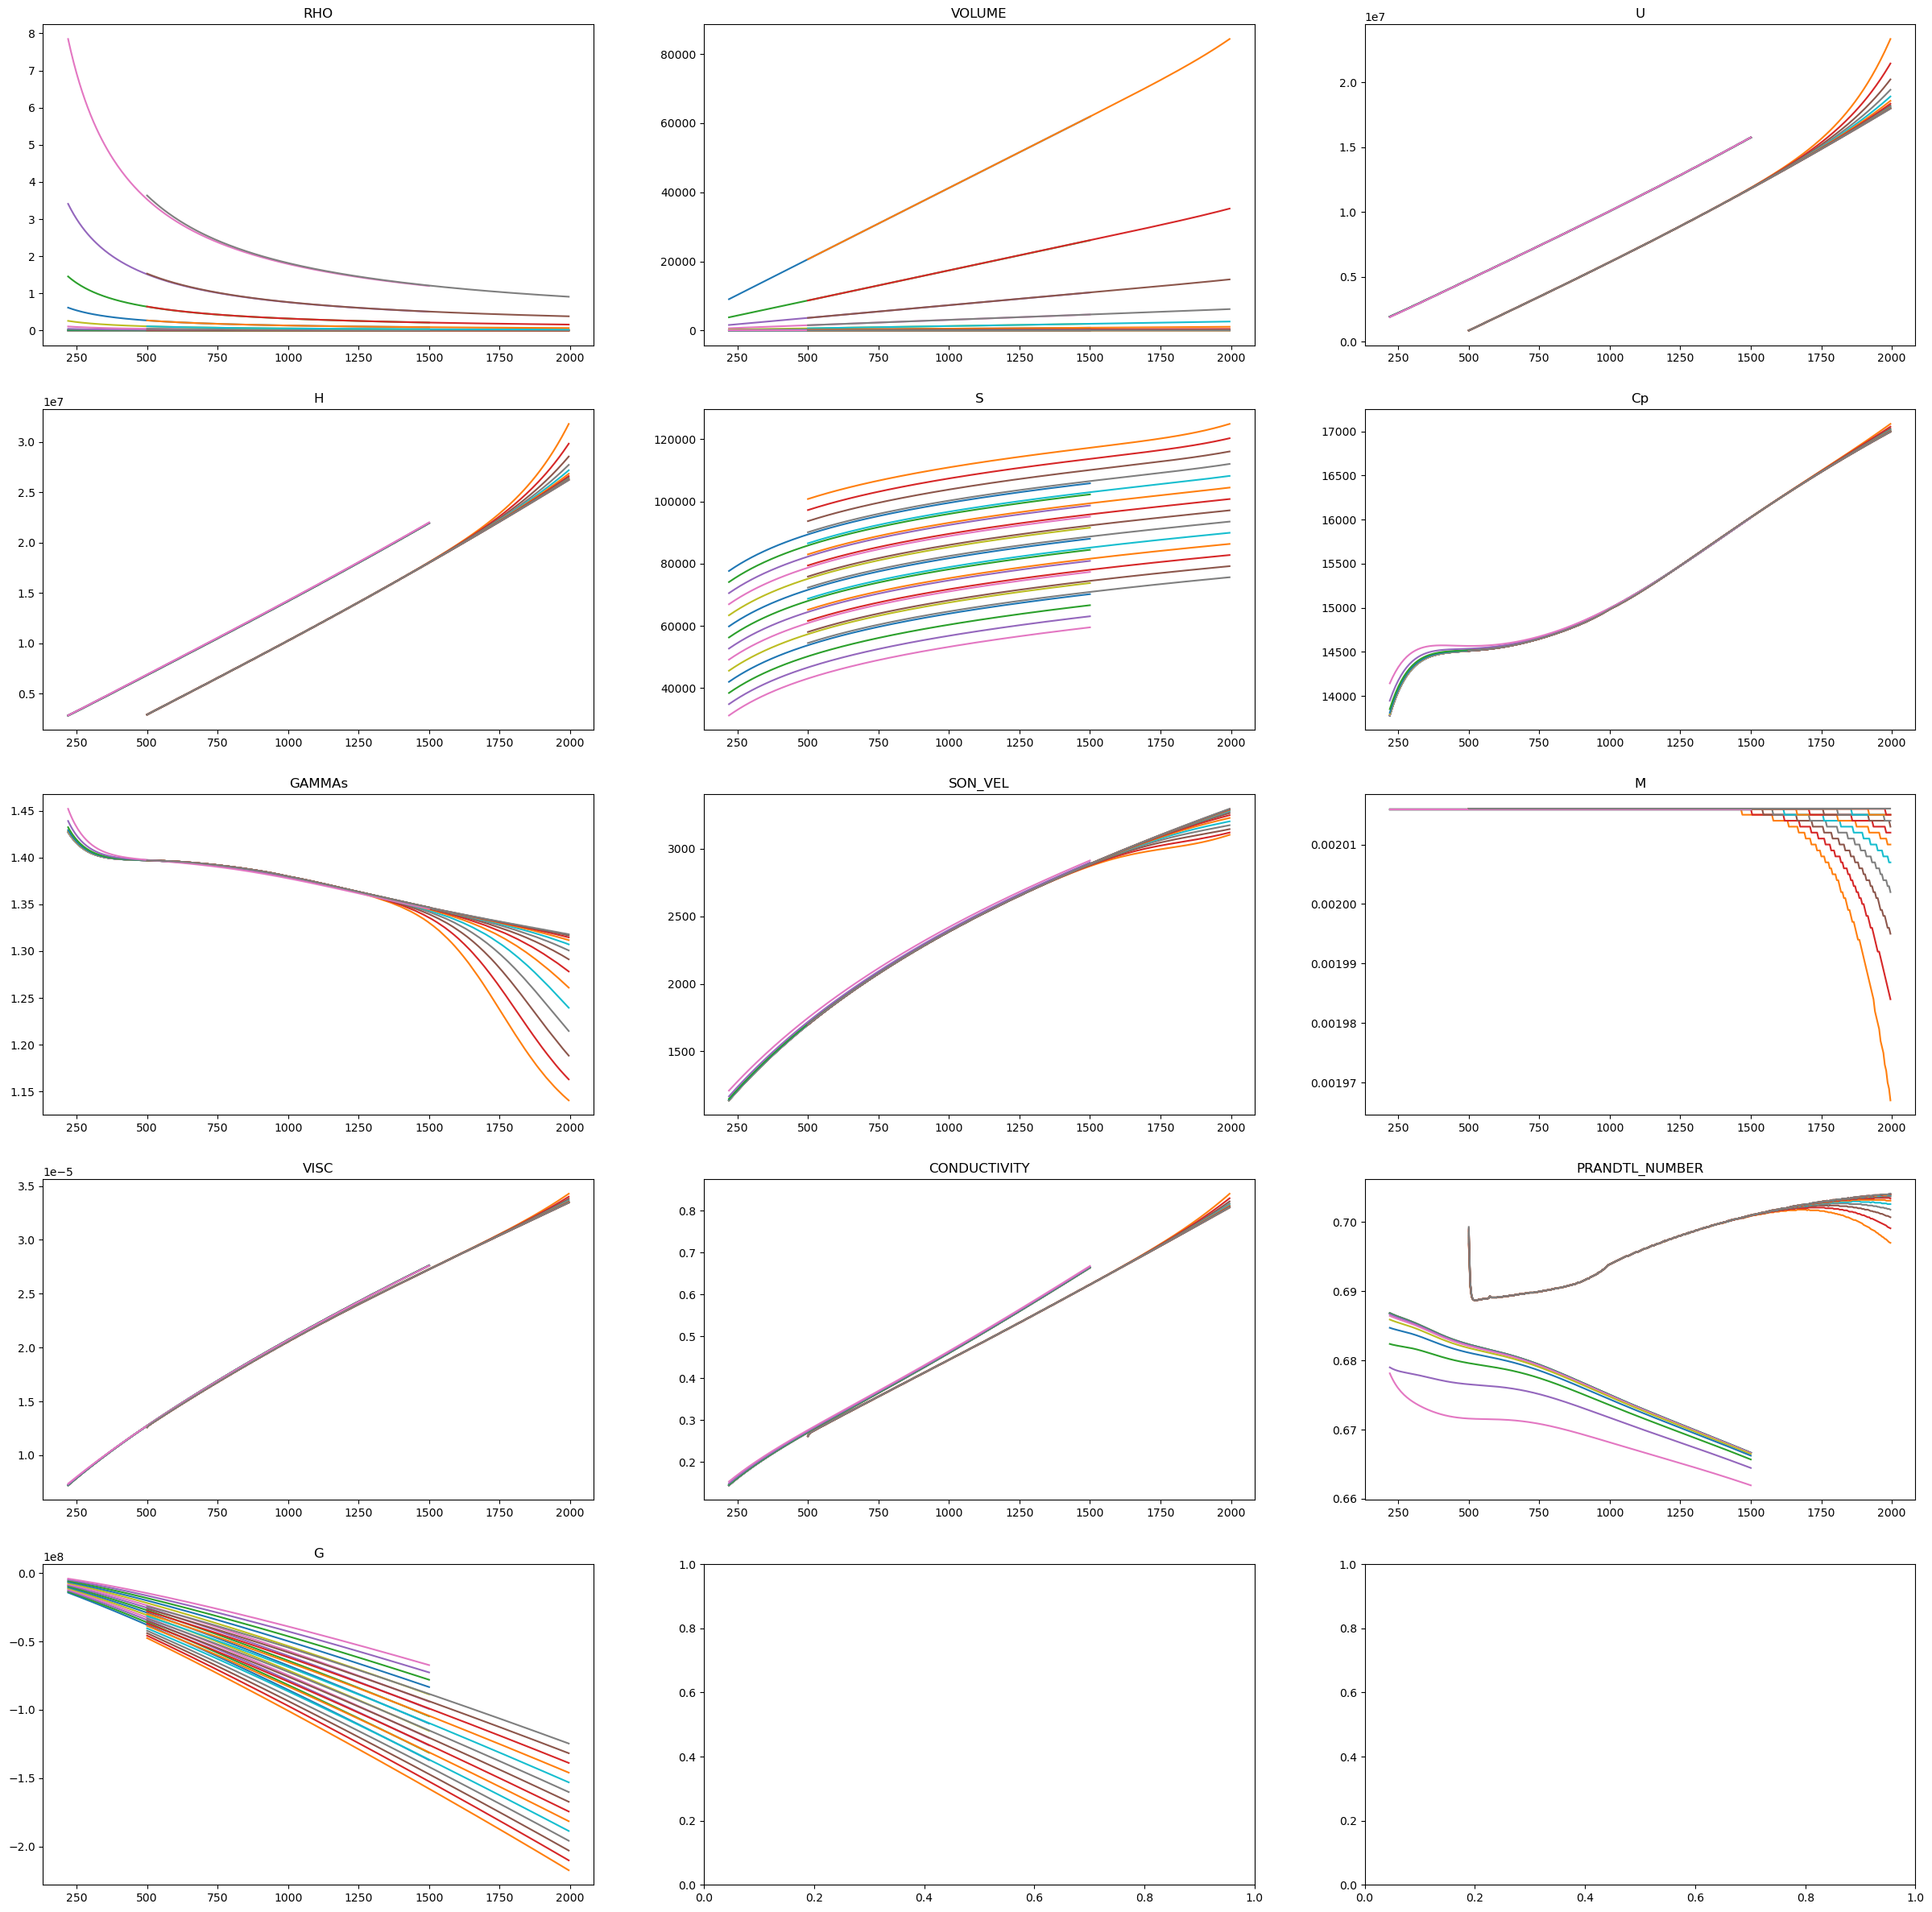

In [4]:
T0 = 40
Tf = -1200
nk = len(cea2.keys())
plt.subplots((nk+2)//3, 3, figsize=(30,30)); j=1
for key in cea2.keys():
    plt.subplot((nk+2)//3, 3, j); j+=1
    for i in range(1,ref2[key].shape[1],15):
        plt.plot(ref2[key][T0:,0], ref2[key][T0:,i]) # , label=f"{ref['H'][0,i]}"
        plt.plot(cea2[key][1:Tf,0], cea2[key][1:Tf,i]) # , label=f"{cea['H, KJ/KG'][0,i]}"
    plt.title(key)

In [5]:
tare = ['U', 'H', 'S', 'G']
loc = (1000, 1500)
idx = lambda arr: (arr>loc[0]) & (arr<loc[1])
cea3 = dict()
for key in tare:
    rnums = ref2[key][1:,1:][idx(ref2[key][1:,0])]
    cnums = cea2[key][1:,1:][idx(cea2[key][1:,0])]
    diff = np.mean(cnums-rnums)
    cea2[key][1:,1:] = cea2[key][1:,1:] - diff

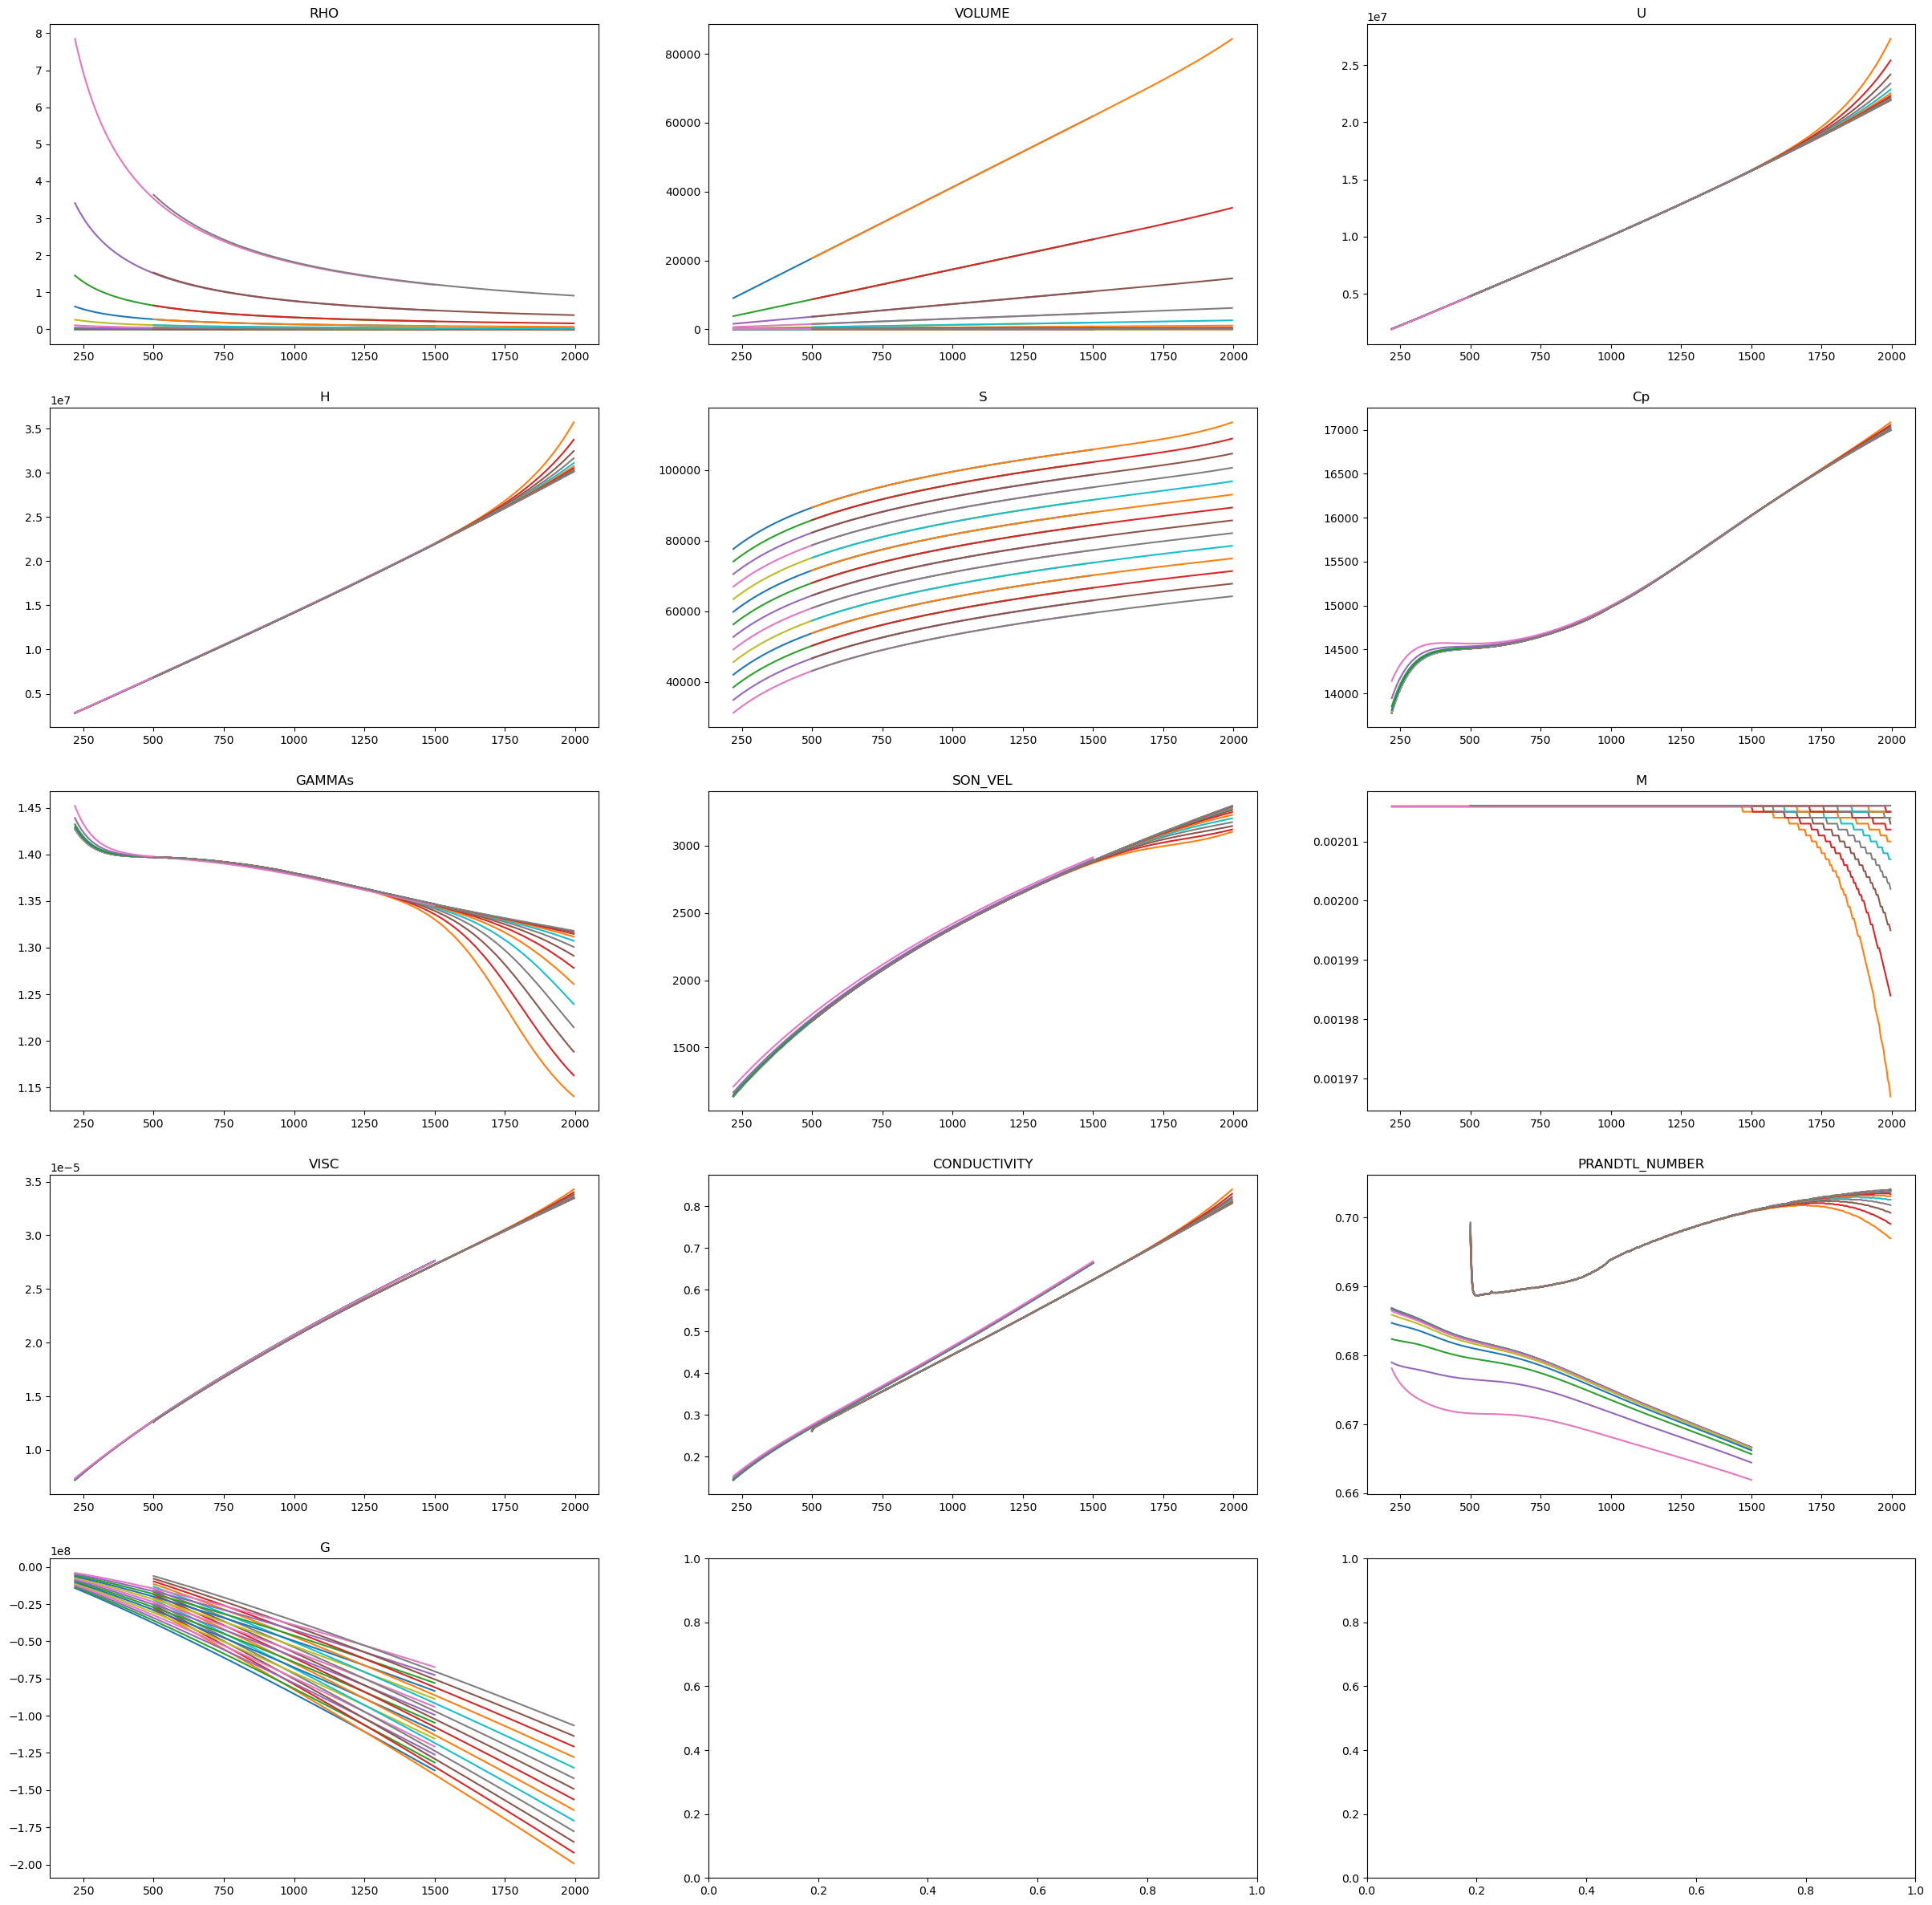

In [6]:
T0 = 40
Tf = -1200
plt.subplots((nk+2)//3, 3, figsize=(30,30)); j=1
for key in cea2.keys():
    plt.subplot((nk+2)//3, 3, j); j+=1
    for i in range(1,ref2[key].shape[1],15):
        plt.plot(ref2[key][T0:,0], ref2[key][T0:,i]) # , label=f"{ref['H'][0,i]}"
        plt.plot(cea2[key][1:Tf,0], cea2[key][1:Tf,i]) # , label=f"{cea['H, KJ/KG'][0,i]}"
    plt.title(key)

In [7]:
combo = dict()
loc = (1000., 1500.)

def qual(arr):          # returns pseudo-'quality' value for interpolation. i.e., the proportion of CEA value to use instead of refprop value.
    q0 = (arr-loc[0])/(loc[1]-loc[0])
    b = [np.zeros(arr.shape), np.ones(arr.shape)]
    return np.max((b[0],np.min((b[1],q0), axis=0)), axis=0)

for key in cea2.keys():          # for each property
    Ts = np.arange(ref2[key][1,0], cea2[key][-1,0]+5,5)     # t-values to index from
    q = qual(Ts)                                            # smoothed unit step, goes from 0->1 over temp range given by `loc`
    wid = cea2[key].shape[1]                                # number of columns
    combo[key] = np.zeros((Ts.shape[0],wid))                
    combo[key][:] = np.nan
    for i in range(Ts.shape[0]):
        refrow = np.where(ref2[key][1:,0]==Ts[i])[0]
        cearow = np.where(cea2[key][1:,0]==Ts[i])[0]
        if refrow.shape[0]>=1:
            r = ref2[key][refrow[0]+1,:]
        else:
            r = np.zeros((1,wid))
        if cearow.shape[0]>=1:
            c = cea2[key][cearow[0]+1,:]
        else:
            c = np.zeros((1,wid))
        combo[key][i,:] = q[i]*c + (1-q[i])*r
    combo[key] = np.concatenate(([ref2[key][0,:]],combo[key]),axis=0)

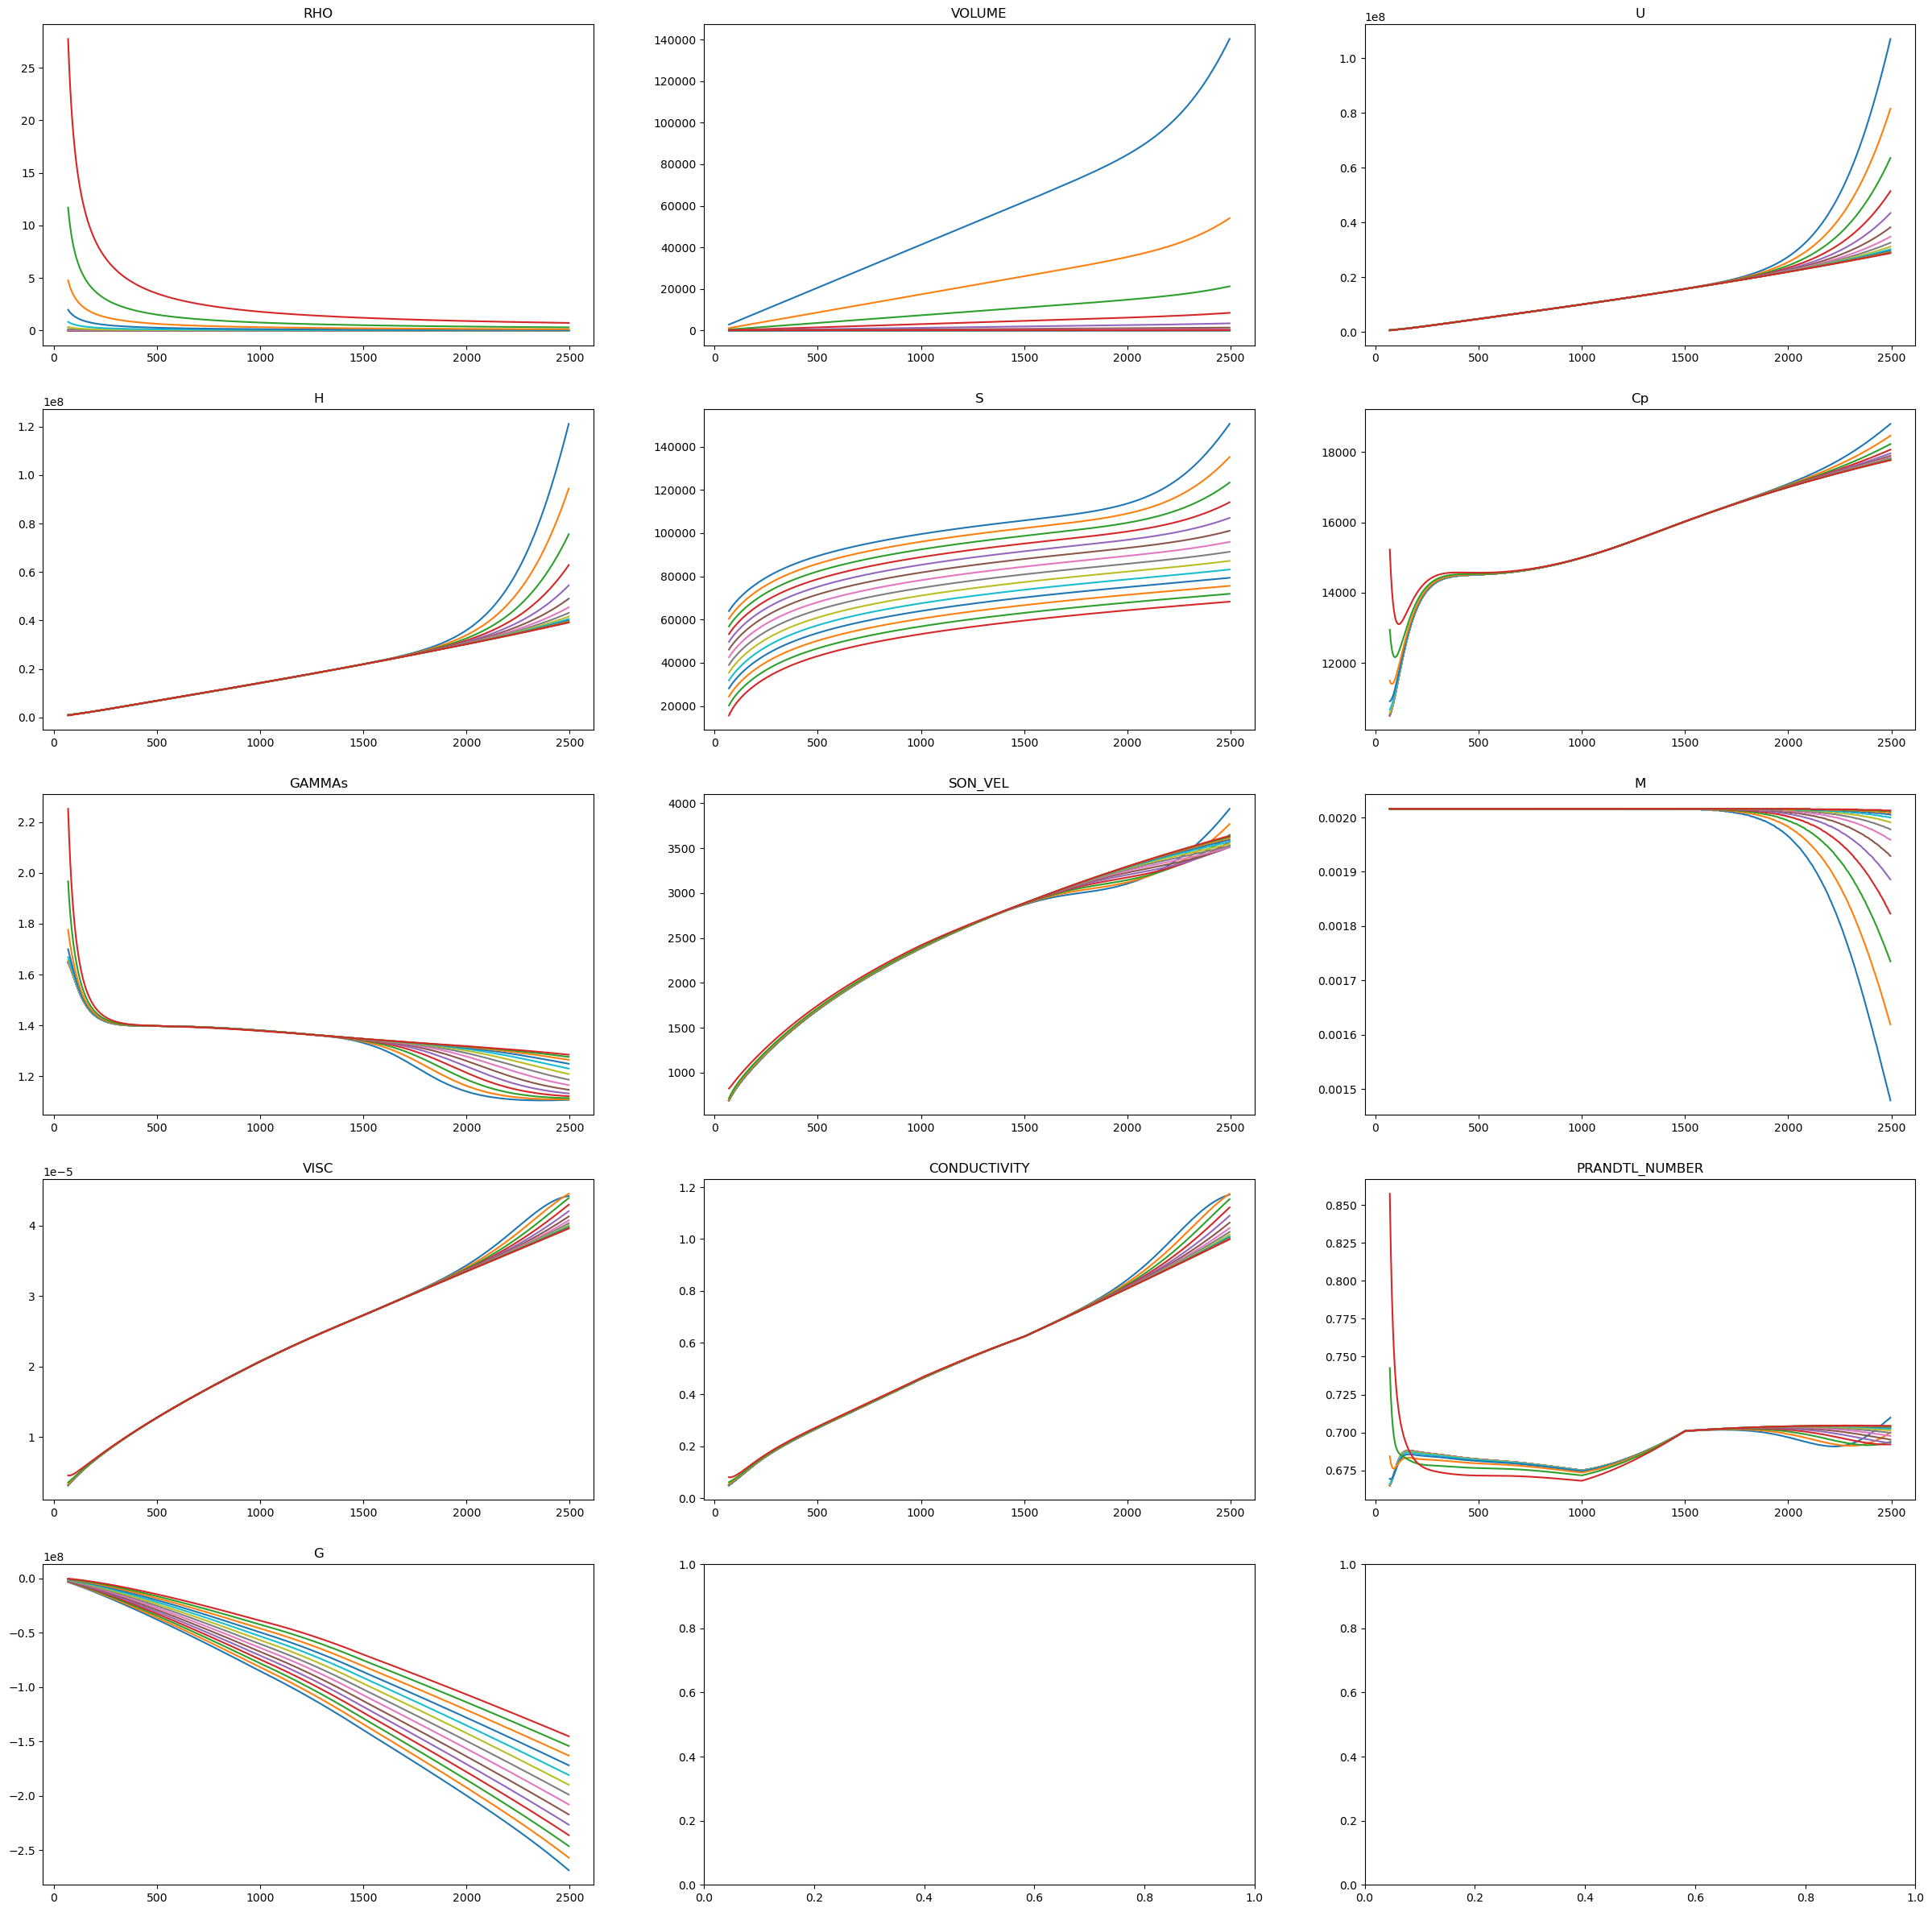

In [8]:
T0 = 10
Tf = -1100
plt.subplots((nk+2)//3, 3, figsize=(30,30)); j=1
for key in cea2.keys():
    plt.subplot((nk+2)//3, 3, j); j+=1
    for i in range(1,ref2[key].shape[1],15):
        plt.plot(combo[key][T0:Tf,0], combo[key][T0:Tf,i]) # , label=f"{ref['H'][0,i]}"
    plt.title(key)

In [9]:
import CEAio
np.savez("H2_compiled.npz", **combo)
CEAio.write_csvs(combo)